Для отрисовки графиков запустить первые 5 ячеек и все, начиная с той, где стоит знак ->

In [1]:
from Assemblies.game import GameField
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [2]:
eps = 0.01
b = 9/5+eps
cp = 50
seeds = np.array([i for i in range(1, 101)])

#процент заполненности решётки, при котором достигается пиковое значение плотности кооператоров
p_star = 80.5
#левая окрестность точки p_star 
points = np.linspace(60, p_star, num=42, dtype=float)

n = len(seeds)
m = len(points)

Вычисляется функция $P(0, \infty)$ - процент игроков, ни разу не менявших свою стратегию на протяжении всего эксперимента с самого его начала. После совершении определённого числа шагов значение $P$ выходит на плато. Наша задача - проводить эксперимент, пока $P$ не выйдет на плато. 

Таким образом, эксперимент прерывается по 3 причинам:
 - поле приходит в стационарное состояние
 - поле непостоянно, но присутствуют устойчивые структуры. Будем проверять это на протяжении 100 ходов.
 - поле совершает установленное число шагов эволюции. Пусть 10000.

In [3]:
def make_field(L, coop_percentage, off_percentage, seed):
    '''
    ---Формирование поля для одного seed---
    
    принимает на вход
    - L - размер поля
    - coop_percentage - начальный процент кооператоров
    - off_percentage - процент отключенных узлов - их количество и расположение на поле постоянно. 
    Величина равна 100 - процент заполненности решётки
    - seed - начальное условие генератора для повторяемости результата
    
    возвращает
    - field - поле по заданным начальным условиям
    '''
    np.random.seed(seed)
    field = np.array(np.random.rand(L, L) <= 0.01 * off_percentage, dtype=int) * (-1)
    active_indexes = (field + 1).nonzero()
    active_size = active_indexes[0].size
    active = np.array(np.random.rand(active_size) > 0.01 * coop_percentage, dtype=int)
    field[active_indexes] = np.copy(active)
    return field

def P(field, b):
    '''
    ---Вычисление P(0, \infty)---
    
    принимает на вход
    - field - поле
    - b - коэффициент выигрыша

    возвращает
    - P
    '''
    active_indexes = (field + 1).nonzero()
    active_size = active_indexes[0].size
    #флаги прохождения проверки на неизменность стратегий: 1 - прошёл, 0 - нет
    flags = np.ones(active_size, dtype=int)
    
    
    L = field[0].size
    game = GameField(L, b)
    game.field = np.copy(field)
    pers_steps = 0
    
    for step in range(10000):
        past = np.copy(game.field[active_indexes])
        game.evolveQ(1)
        now = np.copy(game.field[active_indexes])
        if np.all(past == now):
            break
        #берём игроков, не менявших стратегию за step-1 ходов, и выясняем сколько осталось таких чрез ход
        past_test = past[flags.nonzero()]
        now_test = now[flags.nonzero()]
        #получившийся булевый массив превращаем в 0 и 1 и меняем флаги 
        new_flags = list(map(int, past_test == now_test))
        flags[flags.nonzero()] = new_flags
        if all(nf == 1 for nf in new_flags):
            pers_steps += 1
        else:
            pers_steps = 0
        if pers_steps == 100:
            break
    return np.count_nonzero(flags) / active_size

#### 50x50

In [4]:
pers50 = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        field = make_field(50, cp, 100 - points[j], seeds[i])
        pers50[i][j] = P(field, b)

#### 100x100

In [5]:
pers100 = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        field = make_field(100, cp, 100 - points[j], seeds[i])
        pers100[i][j] = P(field, b)

#### 150x150

In [10]:
pers150 = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        field = make_field(150, cp, 100 - points[j], seeds[i])
        pers150[i][j] = P(field, b)

In [25]:
line_pers50 = list(np.reshape(pers50, (n * m,)))

with open('pers50.txt', 'w', encoding='utf8') as f:
    json.dump(line_pers50, f)
f.close()

line_pers100 = list(np.reshape(pers100, (n * m,)))

with open('pers100.txt', 'w', encoding='utf8') as f:
    json.dump(line_pers100, f)
f.close()

line_pers150 = list(np.reshape(pers150, (n * m,)))

with open('pers150.txt', 'w', encoding='utf8') as f:
    json.dump(line_pers150, f)
f.close()

# ->

In [26]:
with open('pers50.txt', 'r', encoding='utf8') as f:
    copy_pers50 = np.reshape(np.array(json.load(f)), (n, m))
    
with open('pers100.txt', 'r', encoding='utf8') as f:
    copy_pers100 = np.reshape(np.array(json.load(f)), (n, m))
    
with open('pers150.txt', 'r', encoding='utf8') as f:
    copy_pers150 = np.reshape(np.array(json.load(f)), (n, m))

'''
вычисления 200x200 в файле 
https://github.com/bu147/spatial-games-square-grid/blob/master/300x300%2C%20200x200%2C%20100x100%2C%20100%20replics.ipynb
'''
with open('pers.txt', 'r', encoding='utf8') as f:
    copy_pers200 = np.reshape(np.array(json.load(f)), (n, m))

In [27]:
aver50 = np.mean(copy_pers50, axis=0)
errs50 = np.zeros(len(aver50))
for i in range(len(aver50)):
    errs50[i] = np.sqrt(sum((aver50[i] - copy_pers50[::, i]) ** 2) / n) / np.sqrt(n)
    
aver100 = np.mean(copy_pers100, axis=0)
errs100 = np.zeros(len(aver100))
for i in range(len(aver100)):
    errs100[i] = np.sqrt(sum((aver100[i] - copy_pers100[::, i]) ** 2) / n) / np.sqrt(n) 
    
aver150 = np.mean(copy_pers150, axis=0)
errs150 = np.zeros(len(aver150))
for i in range(len(aver150)):
    errs150[i] = np.sqrt(sum((aver150[i] - copy_pers150[::, i]) ** 2) / n) / np.sqrt(n) 
    
aver200 = np.mean(copy_pers200, axis=0)
errs200 = np.zeros(len(aver200))
for i in range(len(aver200)):
    errs200[i] = np.sqrt(sum((aver200[i] - copy_pers200[::, i]) ** 2) / n) / np.sqrt(n)   

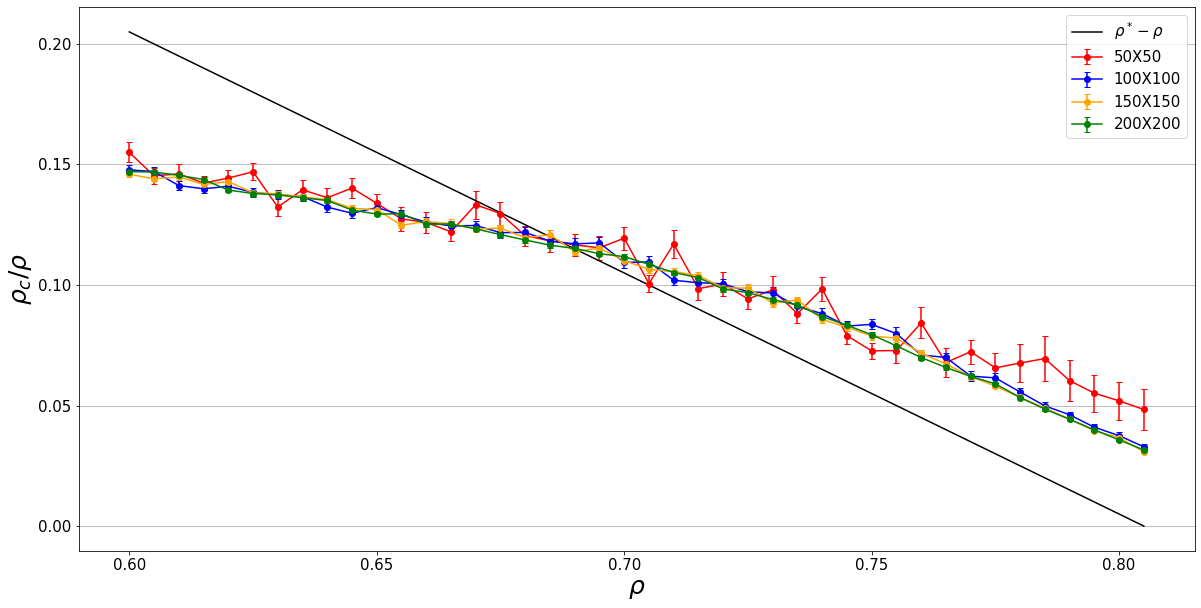

In [28]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.errorbar(points*0.01, aver50, yerr=errs50, fmt='o-', capsize=3, label='50X50', color='red')
ax.errorbar(points*0.01, aver100, yerr=errs100, fmt='o-', capsize=3, label='100X100', color='blue')
ax.errorbar(points*0.01, aver150, yerr=errs150, fmt='o-', capsize=3, label='150X150', color='orange')
ax.errorbar(points*0.01, aver200, yerr=errs200, fmt='o-', capsize=3, label='200X200', color='green')
ax.plot(points*0.01, (p_star - points)*0.01, label='$%s$'%'\\rho^* - \\rho', color='black')

ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'\\rho_c/\\rho',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

Отложим те же графики, но на оси абсцисс теперь не $\rho$, а $\rho^* - \rho$, чтобы проще было увидеть рост

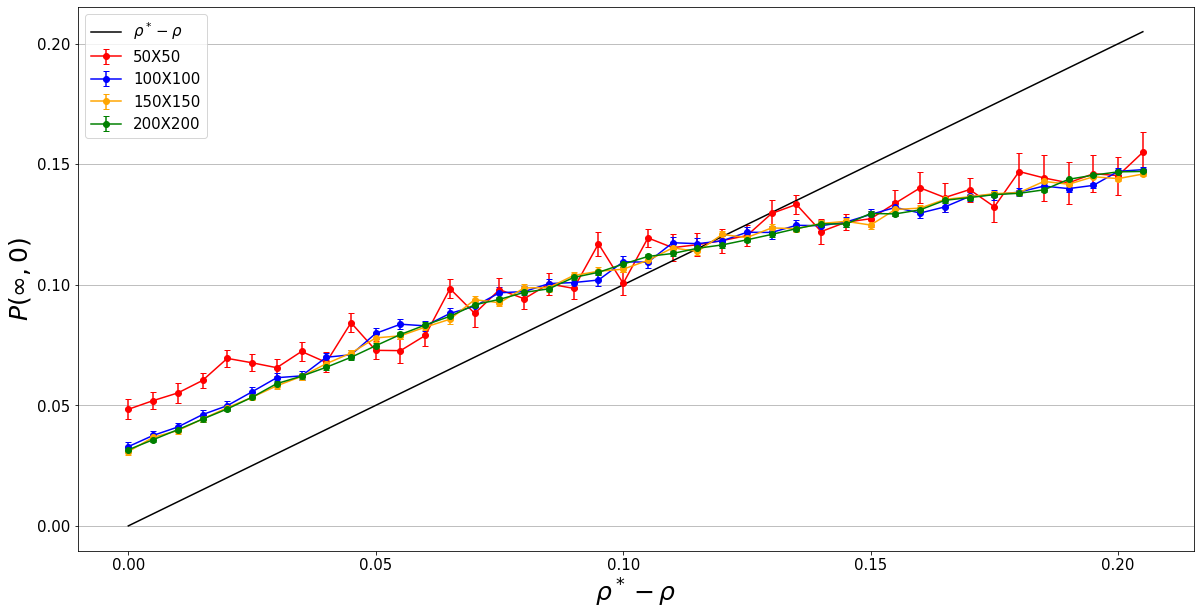

In [29]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.errorbar((p_star - points)[::-1]*0.01, aver50[::-1], yerr=errs50, fmt='o-', capsize=3, label='50X50', color='red')
ax.errorbar((p_star - points)[::-1]*0.01, aver100[::-1], yerr=errs100, fmt='o-', capsize=3, label='100X100', color='blue')
ax.errorbar((p_star - points)[::-1]*0.01, aver150[::-1], yerr=errs150, fmt='o-', capsize=3, label='150X150', color='orange')
ax.errorbar((p_star - points)[::-1]*0.01, aver200[::-1], yerr=errs200, fmt='o-', capsize=3, label='200X200', color='green')
ax.plot((p_star - points)[::-1]*0.01, (p_star - points)[::-1]*0.01, label='$%s$'%'\\rho^* - \\rho', color='black')


ax.set_xlabel('$%s$'%'\\rho^* - \\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

### Первый вариант фитирования

$ P(\infty, 0)\propto (\rho^* - \rho)^\alpha$

$\ln{P(\infty,0)}\propto \alpha \ln{(\rho^* - \rho)}$

In [30]:
pp = (p_star - points)[::-1][1:]*0.01 #исключая ноль
lnpp = np.log(pp)

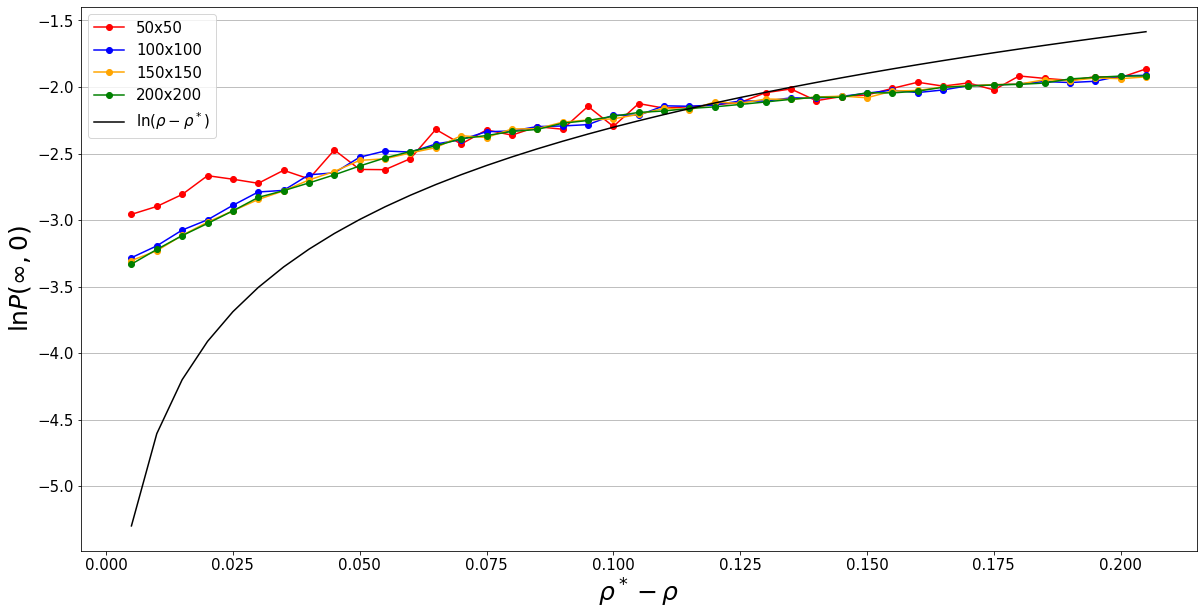

In [31]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

ax.plot(pp, np.log(aver50[::-1][1:]), '-o', label='50x50', color='red')
ax.plot(pp, np.log(aver100[::-1][1:]), '-o', label='100x100', color='blue')
ax.plot(pp, np.log(aver150[::-1][1:]), '-o', label='150x150', color='orange')
ax.plot(pp, np.log(aver200[::-1][1:]), '-o', label='200x200', color='green')
ax.plot(pp, lnpp, label='$%s$'%'\ln{(\\rho - \\rho^*)}', color='black')

ax.set_xlabel('$%s$'%'\\rho^* - \\rho',fontsize=25)
ax.set_ylabel('$%s$'%'\ln{P(\\infty,0)}',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

$\alpha = \langle\frac{\ln{P(\infty,0)}}{\ln{(\rho^* - \rho)}}\rangle$

In [32]:
alpha50 = np.mean(np.log(aver50[::-1][1:]) / lnpp)
print(alpha50)

alpha100 = np.mean(np.log(aver100[::-1][1:]) / lnpp)
print(alpha100)

alpha150 = np.mean(np.log(aver150[::-1][1:]) / lnpp)
print(alpha150)

alpha200 = np.mean(np.log(aver200[::-1][1:]) / lnpp)
print(alpha200)

0.9569218022215249
0.9715705283047801
0.9738832879561229
0.9749998084497835


Итак, высота плато и его степень роста не зависят от размера поля

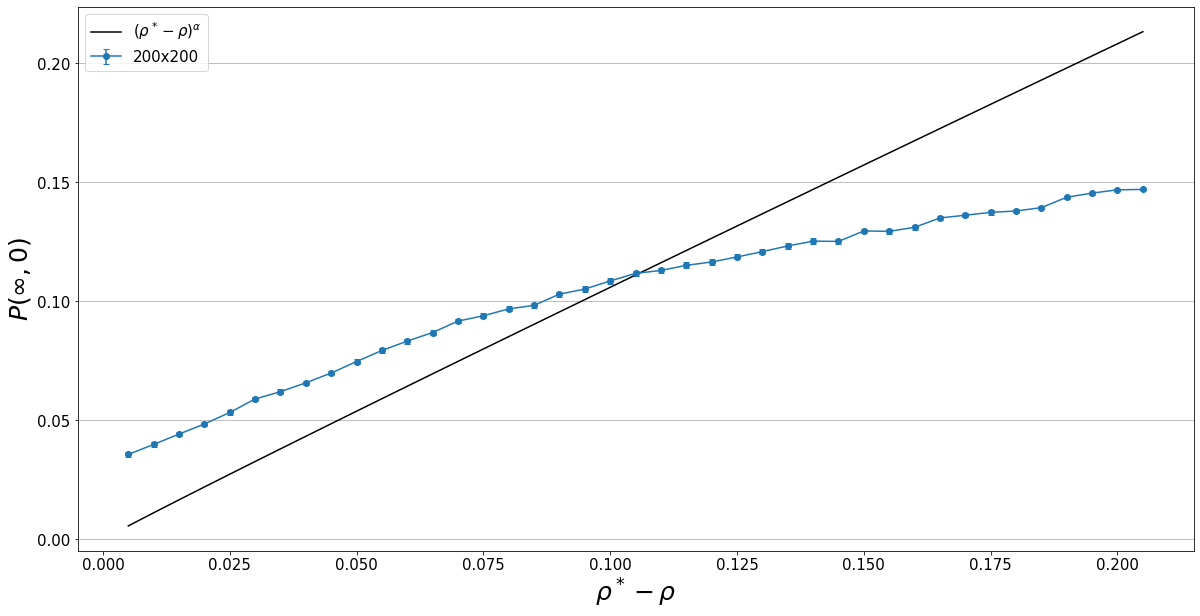

In [33]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.errorbar(pp, aver200[::-1][1:], yerr=errs200[1:], fmt='o-', capsize=3, label='200x200')
ax.plot(pp, pp ** alpha200, label='$%s$'%'(\\rho^* - \\rho)^\\alpha', color='black')
ax.set_xlabel('$%s$'%'\\rho^* - \\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

### Второй вариант фитирования

$P(0, \infty) L^\gamma = A + B (p - p_*) L^\beta$